In [1]:
import sklearn
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

## Precision/Recall

- confusion_matrix
- accuracy_score
- precision_score
- recall_score

In [3]:
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))

In [4]:
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, \
                                                    test_size=0.20, random_state=11)

lr_clf = LogisticRegression(solver='liblinear')

lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test , pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


### predict_proba()

In [5]:
pred_proba = lr_clf.predict_proba(X_test)
pred  = lr_clf.predict(X_test)
print(pred_proba[:3])
pred_proba_result = np.concatenate([pred_proba , pred.reshape(-1,1)],axis=1)
print('\n',pred_proba_result[:3])

[[0.44935228 0.55064772]
 [0.86335513 0.13664487]
 [0.86429645 0.13570355]]

 [[0.44935228 0.55064772 1.        ]
 [0.86335513 0.13664487 0.        ]
 [0.86429645 0.13570355 0.        ]]


### Biniarizer
- threshold 기준값보다 같거나 작으면 0을, 크면 1을 반환

In [6]:
X = [[1,-1,2],[2,0,0],[0,1.1,1.2]]

binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [7]:
custom_threshold = 0.5

pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


### F1 Score

In [8]:
f1 = f1_score(y_test , pred)
f1

0.7966101694915254

## ROC Curve / AUC

### roc_curve(y_true, y_score)
- y_true: 실제 클래스 값 array(array shape = [데이터 건수])
- y_score: predict_prob()의 반환 값 array에서Positive 컬럼의 예측 확률이 보통 사용됨. Binary 분류 시 shape = [n_samples]
- fpr : fpr 값을 array로 반환
- tpr : tpr 값을 array로 반환
- thresholds : thresholds 값 array

In [9]:
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1)

# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임곗값:  [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임곗값별 FPR:  [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임곗값별 TPR:  [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


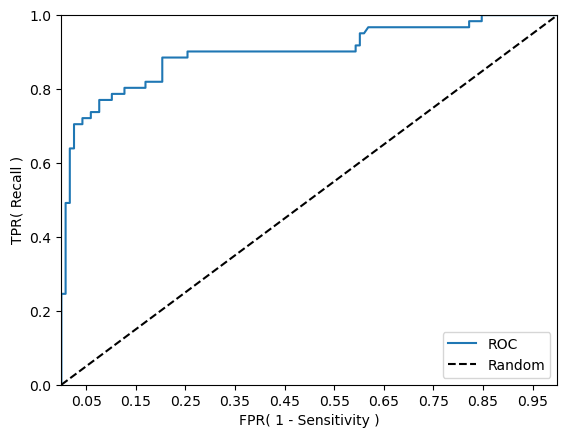

In [10]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )


In [11]:
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8987


# 평가 함수

In [12]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))